In [1]:
import os
import random
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def read_ground_truth_files(file_paths, images_dirs, languages=None):
    """
    Reads multiple ground truth text files.
    Each file is expected to have lines of the form "filename;label".
    
    Parameters:
        file_paths (list[str]): List of ground truth text file paths.
        images_dirs (list[str]): List of corresponding image directories.
        languages (list[str], optional): List of language tags for each file.
        
    Returns:
        pd.DataFrame: Combined DataFrame with columns: filename, label, images_dir, language.
    """
    dataframes = []
    if languages is None:
        languages = [None] * len(file_paths)
    for fp, img_dir, lang in zip(file_paths, images_dirs, languages):
        filenames = []
        labels = []
        with open(fp, 'r', encoding='utf-8') as file:
            for line in file:
                line = line.strip()
                if line:
                    parts = line.split(';')
                    if len(parts) == 2:
                        filename, label = parts
                        filenames.append(filename)
                        labels.append(label.lower())
                    else:
                        print(f"Skipping malformed line: {line}")
        df = pd.DataFrame({'filename': filenames, 'label': labels})
        df['images_dir'] = img_dir
        df['language'] = lang if lang is not None else "default"
        dataframes.append(df)
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df

In [3]:
def build_vocabulary(df):
    """
    Build vocabulary from the 'label' column of the DataFrame.
    
    Returns:
        char_to_idx (dict): Mapping from character to index.
        idx_to_char (dict): Reverse mapping.
        max_label_length (int): Maximum label length (+2 for <SOS> and <EOS>).
    """
    all_text = ''.join(df['label'])
    unique_chars = sorted(list(set(all_text)))
    # Start indices at 1
    char_to_idx = {char: idx + 1 for idx, char in enumerate(unique_chars)}
    # Add special tokens
    char_to_idx['<PAD>'] = 0
    char_to_idx['<UNK>'] = len(char_to_idx)
    char_to_idx['<SOS>'] = len(char_to_idx)
    char_to_idx['<EOS>'] = len(char_to_idx)
    idx_to_char = {v: k for k, v in char_to_idx.items()}
    max_label_length = max(df['label'].apply(len)) + 2
    return char_to_idx, idx_to_char, max_label_length

def encode_label(label, char_to_idx, max_length):
    """
    Encodes a label string into a list of indices including <SOS> and <EOS>,
    and pads the sequence to max_length.
    """
    encoded = [char_to_idx['<SOS>']] + [char_to_idx.get(ch, char_to_idx['<UNK>']) for ch in label] + [char_to_idx['<EOS>']]
    if len(encoded) < max_length:
        encoded += [char_to_idx['<PAD>']] * (max_length - len(encoded))
    else:
        encoded = encoded[:max_length]
    return encoded

def apply_label_encoding(df, char_to_idx, max_length):
    """
    Applies label encoding to the DataFrame.
    Creates two new columns: 'encoded_label' and 'label_length'.
    """
    df['encoded_label'] = df['label'].apply(lambda x: encode_label(x, char_to_idx, max_length))
    df['label_length'] = df['label'].apply(len)
    return df

In [4]:
def custom_split(df, min_count=3, test_size=0.1, random_state=42):
    """
    Splits the DataFrame into training and validation sets.
    Rare labels (frequency < min_count) are kept entirely in the training set.
    
    Parameters:
        df (pd.DataFrame): Full dataset.
        min_count (int): Minimum frequency for a label to be considered non-rare.
        test_size (float): Fraction of non-rare data for validation.
        random_state (int): Random seed.
        
    Returns:
        train_df, val_df (tuple of pd.DataFrame): Training and validation DataFrames.
    """
    label_counts = df['label'].value_counts()
    rare_labels = label_counts[label_counts < min_count].index
    rare_df = df[df['label'].isin(rare_labels)]
    non_rare_df = df[~df['label'].isin(rare_labels)]
    
    train_nr, val_nr = train_test_split(non_rare_df, test_size=test_size, random_state=random_state)
    train_df = pd.concat([train_nr, rare_df], ignore_index=True)
    train_df = train_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    val_df = val_nr.reset_index(drop=True)
    return train_df, val_df

In [5]:
def get_normal_transform():
    """Normal transform: Resize, convert to tensor, and normalize."""
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

def get_augmented_transform():
    """Augmented transform: Applies random blur, color jitter, and rotation."""
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        transforms.RandomRotation(degrees=(-5, 5)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

def select_transform(augmentation=False):
    """
    Returns the appropriate transformation pipeline based on the augmentation flag.
    
    Parameters:
        augmentation (bool): If True, returns augmented transform; otherwise, normal.
    """
    if augmentation:
        return get_augmented_transform()
    else:
        return get_normal_transform()

def tensor_to_image(tensor):
    """Converts a normalized tensor back to an image (numpy array) for visualization."""
    tensor = tensor.clone() * 0.5 + 0.5
    tensor = tensor.clamp(0, 1)
    return tensor.permute(1, 2, 0).numpy()

In [6]:
class BalineseDataset(Dataset):
    """
    Custom Dataset that loads images and returns the encoded label and its length.
    """
    def __init__(self, df, images_dir, transform=None):
        self.data = df.reset_index(drop=True)
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.loc[idx, 'filename']
        label = self.data.loc[idx, 'encoded_label']
        label_length = self.data.loc[idx, 'label_length']
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)
        return image, label, torch.tensor(label_length, dtype=torch.long)

def create_data_loaders(df, images_dir, transform, batch_size=32, shuffle=True, num_workers=2, pin_memory=True):
    """
    Creates a DataLoader for the dataset.
    
    Parameters:
        df (pd.DataFrame): Dataset DataFrame.
        images_dir (str): Directory where images are stored.
        transform: Transformation pipeline.
        batch_size (int): Batch size.
        shuffle (bool): Whether to shuffle the data.
        
    Returns:
        DataLoader: PyTorch DataLoader for the dataset.
    """
    dataset = BalineseDataset(df, images_dir, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=pin_memory)
    return loader

In [7]:
def show_random_augmentation_example(train_df, images_dir, augmentation=False):
    """
    Selects a random image from the training set and displays its normal and augmented versions side by side.
    
    Parameters:
        train_df (pd.DataFrame): Training dataset DataFrame.
        images_dir (str): Image directory.
        augmentation (bool): If True, applies augmented transform; otherwise, normal transform.
    """
    transform = select_transform(augmentation)
    random_idx = random.randint(0, len(train_df) - 1)
    img_name = train_df.iloc[random_idx]['filename']
    img_path = os.path.join(images_dir, img_name)
    image = Image.open(img_path).convert("RGB")
    
    normal = get_normal_transform()
    aug = transform
    
    image_normal = normal(image)
    image_aug = aug(image)
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(tensor_to_image(image_normal))
    axes[0].set_title("Normal Transform")
    axes[0].axis("off")
    axes[1].imshow(tensor_to_image(image_aug))
    axes[1].set_title("Augmented Transform" if augmentation else "Normal Transform")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

Combined Data:
     filename    label                              images_dir  language
0  train1.png  kagastu  /home/yhuang1/data/balinese_word_train  balinese
1  train2.png        ,  /home/yhuang1/data/balinese_word_train  balinese
2  train3.png    gelak  /home/yhuang1/data/balinese_word_train  balinese
3  train4.png    ancak  /home/yhuang1/data/balinese_word_train  balinese
4  train5.png        ,  /home/yhuang1/data/balinese_word_train  balinese
Training size: 13972; Validation size: 1050
Sample batch encoded labels: tensor([[37, 14, 23, 30, 14, 29, 14, 26, 21, 14, 38,  0,  0,  0,  0,  0,  0,  0],
        [37, 30, 27, 31, 18, 26, 19, 38,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [37, 30, 14, 28, 32, 20, 14, 26, 19, 38,  0,  0,  0,  0,  0,  0,  0,  0],
        [37,  1, 38,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [37,  1, 38,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [37,  1, 38,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

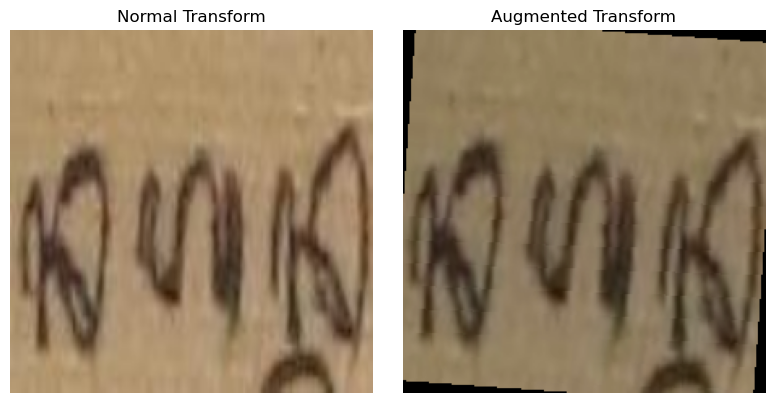

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_dir = os.getcwd()

# Define lists of file paths, corresponding image directories, and languages
file_paths = [os.path.join(base_dir, 'balinese_transliteration_train.txt')]
images_dirs = [os.path.join(base_dir, 'balinese_word_train')]
languages = ['balinese']  # Extend lists if more files are used

#Read files
df = read_ground_truth_files(file_paths, images_dirs, languages)
print("Combined Data:")
print(df.head())

#Build vocabulary and encode labels
char_to_idx, idx_to_char, max_label_length = build_vocabulary(df)
df = apply_label_encoding(df, char_to_idx, max_label_length)

# Custom split (rare labels are kept in training)
train_df, val_df = custom_split(df, min_count=3, test_size=0.1, random_state=42)
print(f"Training size: {len(train_df)}; Validation size: {len(val_df)}")

# Create DataLoaders (choose augmentation True/False)
transform_aug = select_transform(augmentation=True)
transform_norm = get_normal_transform()
train_loader = create_data_loaders(train_df, images_dirs[0], transform_aug, batch_size=32, shuffle=True)
val_loader = create_data_loaders(val_df, images_dirs[0], transform_norm, batch_size=32, shuffle=False)

# Print a sample batch from the training loader
sample_batch = next(iter(train_loader))
images, labels, label_lengths = sample_batch
print("Sample batch encoded labels:", labels)
print("Sample batch label lengths:", label_lengths)

# 5. Show augmentation example (set augmentation to True or False)
show_random_augmentation_example(train_df, images_dirs[0], augmentation=True)